# CTR9 KO Simulation with CellOracle

This notebook performs an **in silico CTR9 knockout simulation** using CellOracle, following the tutorial structure from the Gata1 KO example.

### Input data
- **Oracle object**: `celloracle_results/wt_CTR9.celloracle.oracle` (from `celloracle_wt_GRNcalculation.ipynb`)
- **Links object**: `celloracle_results/CTR9_WT_3000HVG_filtered.celloracle.links` (filtered & scored links)

### What this notebook does
1. **In silico TF perturbation** — simulate CTR9 KO and predict cell identity shifts
2. **Visualization** — quiver plots and vector field maps of perturbation effects
3. **Compare with developmental vectors** — calculate perturbation scores (PS) using pseudotime gradients
4. **Lineage-specific analysis** — focus on specific clusters of interest

# 0. Import libraries

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

/home/hdlab/miniconda3/envs/celloracle_env/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
import celloracle as co
co.__version__

/home/hdlab/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


'0.20.0'

In [3]:
plt.rcParams["figure.figsize"] = [6, 6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300

%matplotlib inline

In [4]:
# Make folder to save plots
save_folder = "figures_CTR9_KO"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed Oracle object

In [5]:
# Load the oracle object from GRN calculation notebook
oracle = co.load_hdf5("celloracle_results/wt_CTR9.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.20.0
    n_cells: 4981
    n_genes: 14998
    cluster_name: cluster_annot
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 24599 genes
    n_regulatory_in_TFdict: 1094 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 374 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 10598 genes
    k_for_knn_imputation: 124
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

In [6]:
# Quick check of the data
print(f"Number of cells: {oracle.adata.shape[0]}")
print(f"Number of genes: {oracle.adata.shape[1]}")
print(f"Cluster column: {oracle.cluster_column_name}")
print(f"Embedding: {oracle.embedding_name}")
print(f"\nClusters:")
print(oracle.adata.obs[oracle.cluster_column_name].value_counts())

Number of cells: 4981
Number of genes: 14998
Cluster column: cluster_annot
Embedding: X_umap

Clusters:
Adipocyte               1087
Epi_Kit+Elf5+            935
Epi_Ctr9+                664
Fibroblasts              538
BasalEpi_Acta2+Trp63     519
Tcells                   453
Bcells                   307
Endothelials             158
Myeloid_cells            150
Pericytes/SMC             53
Epi_proliferating         47
DCs                       41
SMC?                      16
Schwann?                  13
Name: cluster_annot, dtype: int64


## 1.2. Load inferred GRNs (filtered Links object)

In [7]:
# Load the filtered links object
links = co.load_hdf5("celloracle_results/CTR9_WT_3000HVG_filtered.celloracle.links")

# 2. Make predictive models for simulation

We need to fit ridge regression models again using the filtered GRN models. This is faster than the original GRN inference.

In [8]:
%%time
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/14 [00:00<?, ?it/s]

CPU times: user 4min 31s, sys: 5min 1s, total: 9min 32s
Wall time: 2min 26s


# 3. In silico CTR9 KO simulation

simulate the knockout of **CTR9** by setting its expression to 0.

## 3.1. Check CTR9 gene expression pattern

In [9]:
# Define gene of interest
goi = "Ctr9"

# IMPORTANT: Check if the gene is in the data with the correct capitalization
# Mouse genes are typically capitalized like "Ctr9" not "CTR9"
# Uncomment and run the line below to search for the gene name
print("Searching for CTR9/Ctr9 in gene list...")
matching = [g for g in oracle.adata.var_names if 'ctr9' in g.lower()]
print(f"Matching genes: {matching}")

# Update goi if needed based on the output above
if len(matching) > 0:
    goi = matching[0]
    print(f"\nUsing gene name: {goi}")
else:
    print("\n⚠️  CTR9/Ctr9 not found in HVG list!")
    print("This can happen if CTR9 was not in the top 3000 highly variable genes.")
    print("Options:")
    print("  1. Re-run GRN calculation with more HVGs to include CTR9")
    print("  2. Try a different gene target")

Searching for CTR9/Ctr9 in gene list...
Matching genes: ['Ctr9']

Using gene name: Ctr9


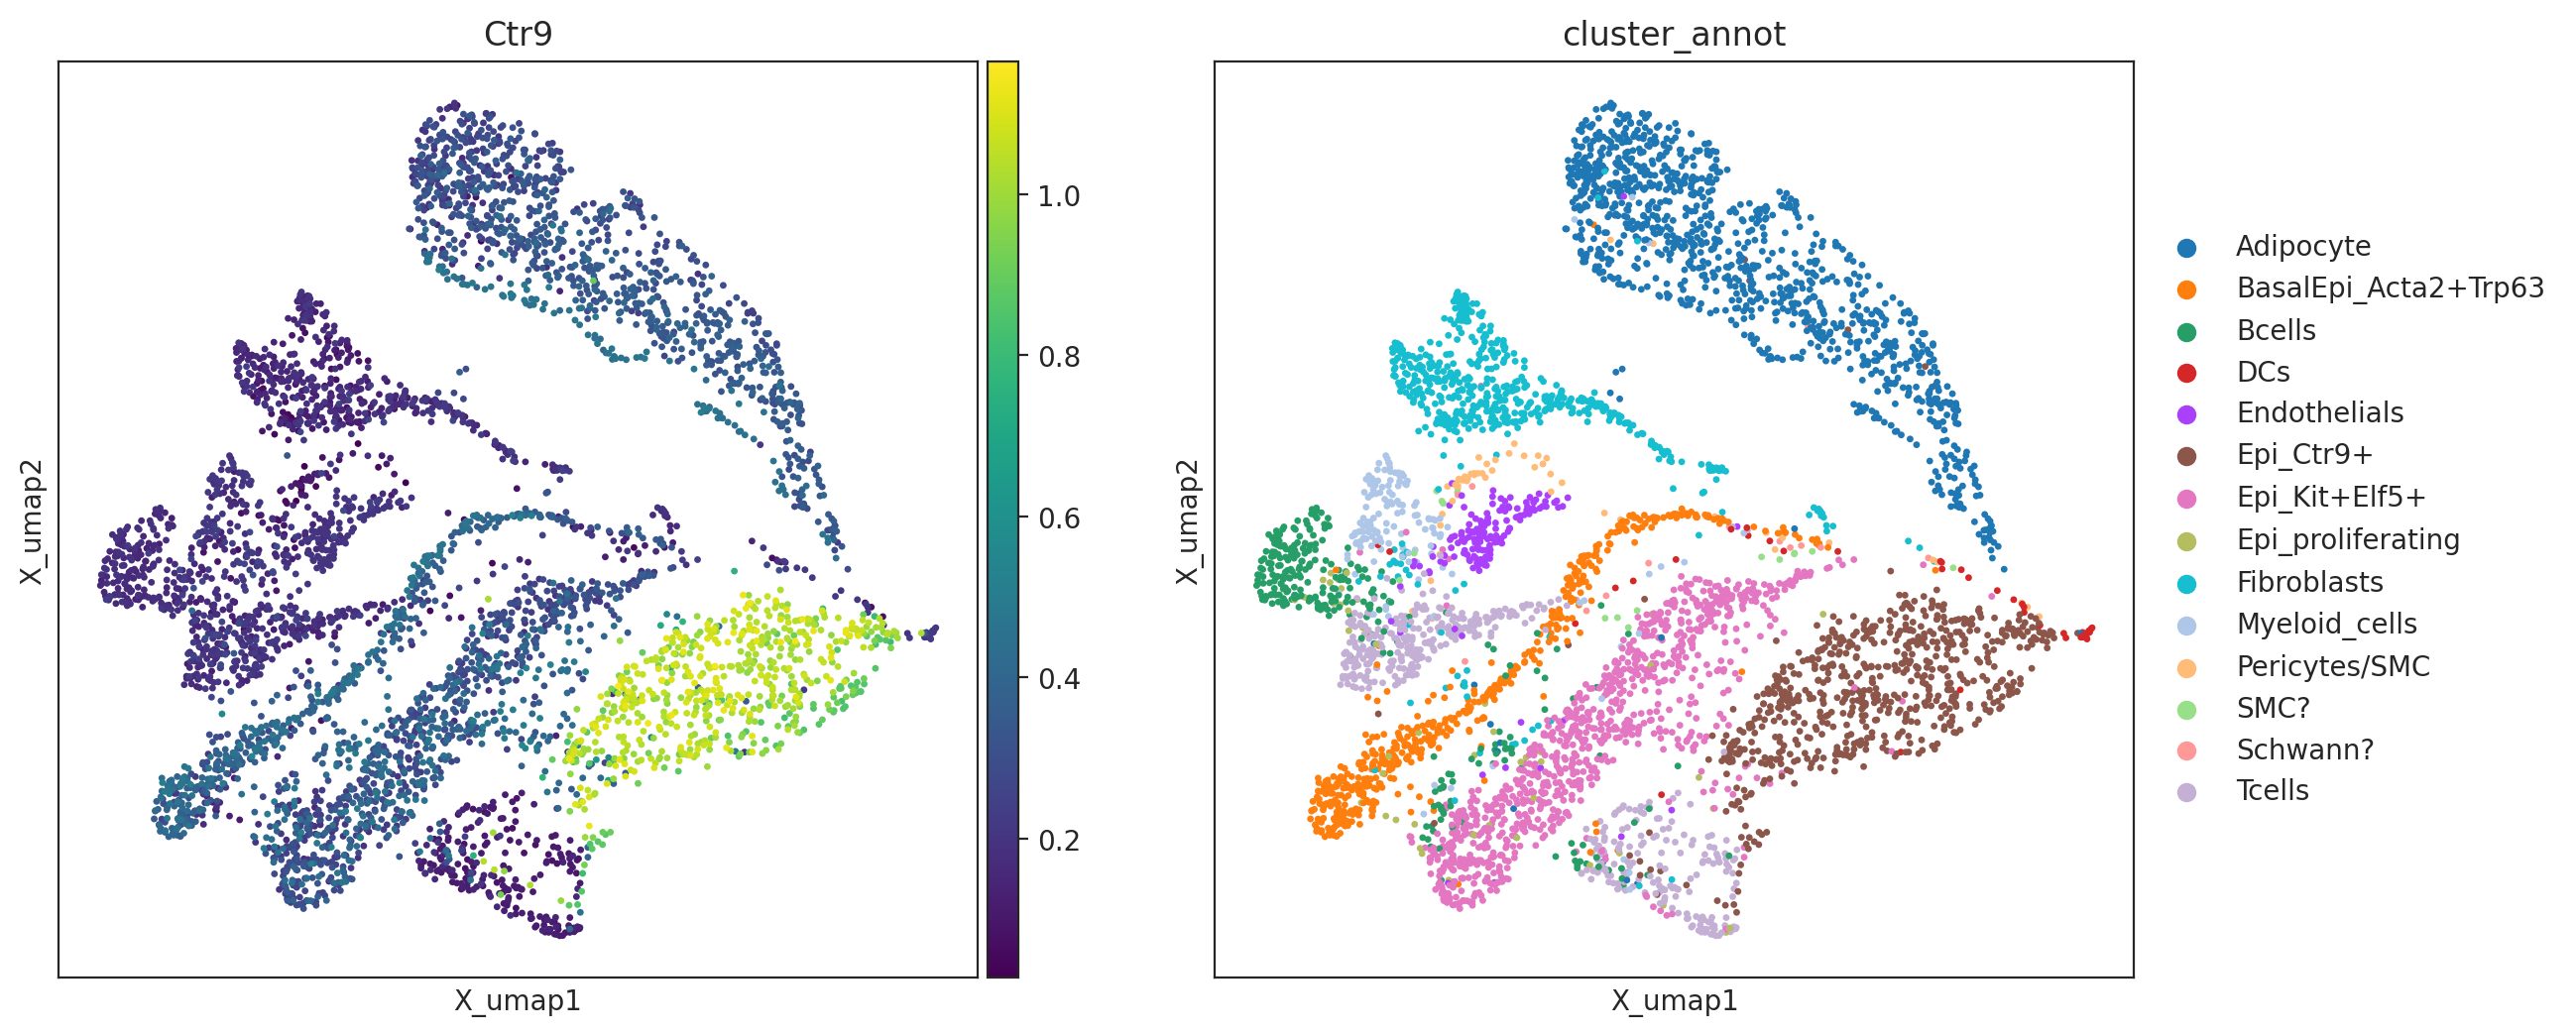

In [10]:
# Visualize gene expression on embedding
sc.pl.embedding(oracle.adata, basis=oracle.embedding_name,
                color=[goi, oracle.cluster_column_name],
                layer="imputed_count", use_raw=False, cmap="viridis")

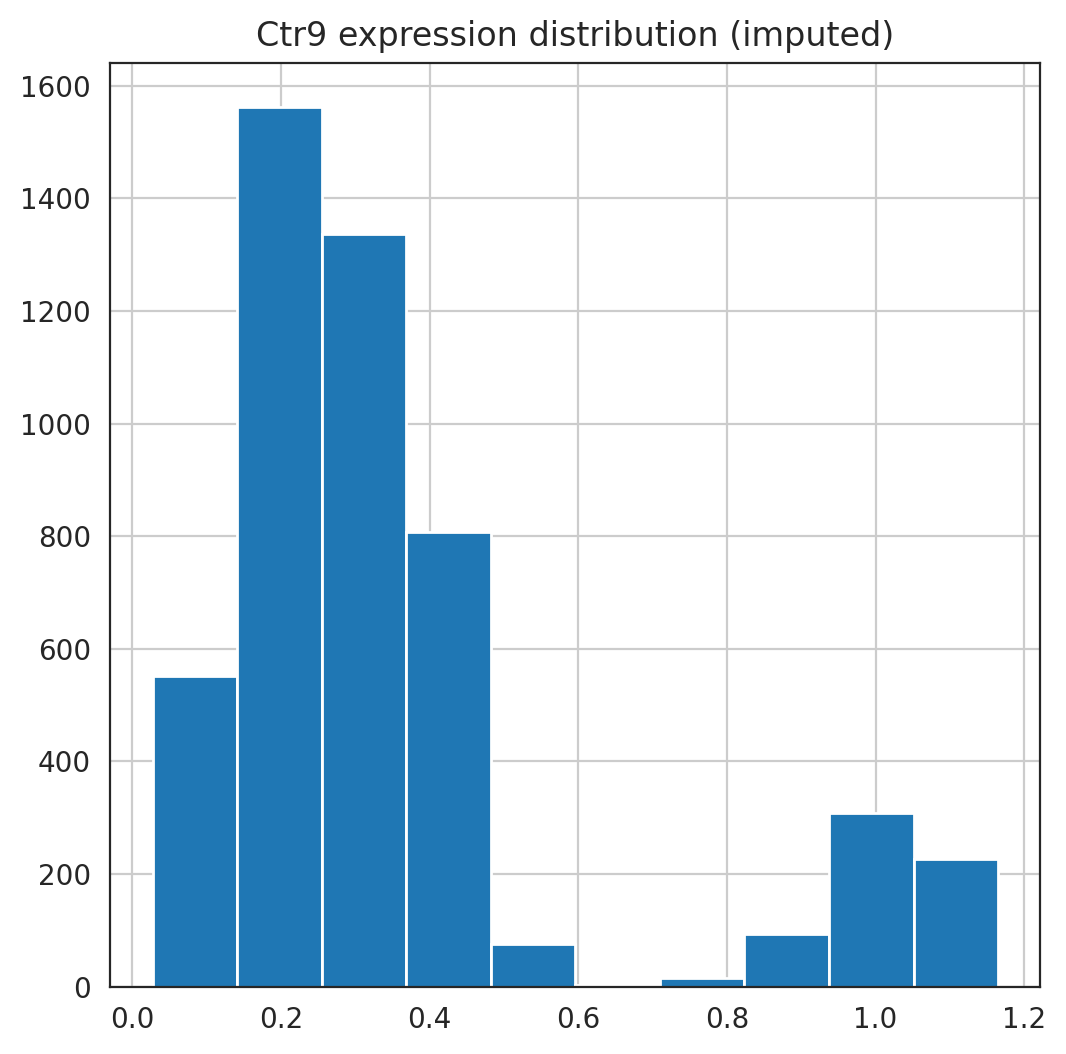

In [11]:
# Plot gene expression histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.title(f"{goi} expression distribution (imputed)")
plt.show()

## 3.2. Simulate CTR9 KO

To simulate KO, set the gene expression to 0 or simulate partial knockdown by using a value between 0 and the normal expression level.

In [12]:
# Simulate CTR9 KO (set expression to 0)
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

ValueError: Gene Ctr9 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.

## 3.3. Calculate transition probability

In [ ]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True, 
                                sampled_fraction=1)

# Calculate embedding shift
oracle.calculate_embedding_shift(sigma_corr=0.05)

# 4. Visualization
## 4.1. Quiver plot — single cell resolution

**Important:** Adjust the `scale` parameter for your data.
- If vectors are not visible → try a smaller `scale`
- If randomized results (right panel) show large vectors → `scale` is too small

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=[13, 6])

# ADJUST this scale parameter for your data
scale = 25

# Simulation quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Randomized control
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.tight_layout()
plt.savefig(f"{save_folder}/{goi}_KO_quiver.png", dpi=300, bbox_inches='tight')
plt.show()

## 4.2. Vector field on grid

### 4.2.1. Find parameters for n_grid and min_mass

In [ ]:
# n_grid = 40 is a good starting value
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

In [ ]:
# Search for best min_mass threshold
oracle.suggest_mass_thresholds(n_suggestion=12)

In [ ]:
# ADJUST min_mass based on the suggestion above
min_mass = 0.01  # <-- UPDATE this based on suggest_mass_thresholds output
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

### 4.2.2. Plot vector fields

Adjust `scale_simulation` — same principle as above.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=[13, 6])

# ADJUST scale for vector field visualization
scale_simulation = 0.5

# Simulation vector field
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Randomized control
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.tight_layout()
plt.savefig(f"{save_folder}/{goi}_KO_vector_field.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Plot vector field overlaid on cell clusters
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

plt.title(f"{goi} KO simulation — vector field with clusters")
plt.savefig(f"{save_folder}/{goi}_KO_vector_field_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. [Optional] Compare simulation vectors with developmental vectors

## 5.0. Overview

To interpret the perturbation results in the context of development, we compare the simulation vectors with pseudotime gradient vectors and calculate a **perturbation score (PS)**:

- **Negative PS** → TF perturbation would **block differentiation**
- **Positive PS** → TF perturbation would **promote differentiation**

## 5.1. Prepare pseudotime data

⚠️ **You need pseudotime calculated for your data before proceeding.** If you don't have it yet, see:
- CellOracle pseudotime tutorial: https://morris-lab.github.io/CellOracle.documentation/tutorials/pseudotime.html
- You can use diffusion pseudotime, Palantir, or other methods

The pseudotime values should be stored in `oracle.adata.obs["Pseudotime"]`.

In [ ]:
# Check if pseudotime is already in the data
pseudotime_candidates = [col for col in oracle.adata.obs.columns if 'pseudo' in col.lower() or 'dpt' in col.lower()]
print("Potential pseudotime columns:", pseudotime_candidates)
print("\nAll obs columns:", list(oracle.adata.obs.columns))

In [ ]:
# ============================================================
# OPTION A: If pseudotime already exists, set the key name here
# ============================================================
# pseudotime_key = "Pseudotime"  # or "dpt_pseudotime", etc.

# ============================================================
# OPTION B: Calculate diffusion pseudotime with scanpy
# ============================================================
# Uncomment and run the block below if you need to calculate pseudotime

# # Make sure neighbors are computed
# if 'neighbors' not in oracle.adata.uns:
#     sc.pp.neighbors(oracle.adata)

# # Compute diffusion map
# sc.tl.diffmap(oracle.adata)

# # Set a root cell (ADJUST: pick a cell index that represents your starting state)
# # You can identify root cells by examining cluster identity or marker expression
# oracle.adata.uns['iroot'] = 0  # <-- ADJUST: index of root cell

# # Calculate DPT
# sc.tl.dpt(oracle.adata)

# # Rename to Pseudotime for compatibility
# oracle.adata.obs["Pseudotime"] = oracle.adata.obs["dpt_pseudotime"].copy()
# pseudotime_key = "Pseudotime"

# ============================================================
# Set your pseudotime key here
# ============================================================
pseudotime_key = "Pseudotime"  # <-- ADJUST to match your pseudotime column name

## 5.2. Visualize pseudotime

In [ ]:
fig, ax = plt.subplots(figsize=[6, 6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=[pseudotime_key])

## 5.3. Make Gradient_calculator object

In [ ]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key=pseudotime_key)

In [ ]:
# Use the same n_grid and min_mass as step 4.2.1
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

## 5.4. Transfer pseudotime values to grid points

In [ ]:
# Transfer pseudotime data into grid
# Two methods available:
#   - "polynomial": more robust, good default (adjust n_poly)
#   - "knn": alternative method (adjust n_knn)

gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly": 3}, plot=True)

## 5.5. Calculate gradient vectors

In [ ]:
# Calculate gradient
gradient.calculate_gradient()

# Visualize — ADJUST scale_dev for your data
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

In [ ]:
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)
plt.title("Pseudotime gradient vector field")
plt.savefig(f"{save_folder}/pseudotime_gradient.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Save gradient object
gradient.to_hdf5(f"celloracle_results/CTR9_WT.celloracle.gradient")

## 5.6. Calculate perturbation scores (inner product)

The inner product between the simulation vectors and developmental vectors gives us the **perturbation score (PS)**:
- **Negative PS** → perturbation **blocks** differentiation
- **Positive PS** → perturbation **promotes** differentiation

In [ ]:
from celloracle.applications import Oracle_development_module

# Make Oracle_development_module to compare two vector fields
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)

# Calculate inner product scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

## 5.7. Visualize perturbation scores

Adjust `vm` parameter for color scale:
- If no color visible → try smaller `vm`
- If randomized results show colors → `vm` is too small

In [ ]:
# ADJUST vm for color visualization
vm = 0.02

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax[0])
ax[0].set_title(f"Perturbation Score: {goi} KO")

dev.plot_inner_product_random_on_grid(vm=vm, s=50, ax=ax[1])
ax[1].set_title(f"PS — Randomized simulation vector")

plt.tight_layout()
plt.savefig(f"{save_folder}/{goi}_KO_perturbation_scores.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Perturbation scores overlaid with simulation vector field
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)
plt.title(f"{goi} KO — PS with simulation vectors")
plt.savefig(f"{save_folder}/{goi}_KO_PS_with_vectors.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Comprehensive visualization layout
dev.visualize_development_module_layout_0(s=5, 
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev, 
                                          vm=vm)

# 6. [Optional] Focus on specific lineage / cluster subpopulation

You can re-run the perturbation score analysis on a subset of cells to focus on a specific lineage.

In [ ]:
# Check available clusters
print("Available clusters:")
for i, clust in enumerate(oracle.adata.obs[oracle.cluster_column_name].unique()):
    print(f"  {i}: {clust}")

In [ ]:
# ADJUST: Select clusters for the lineage of interest
# Example — replace with your actual cluster names
clusters_of_interest = ["cluster_1", "cluster_2"]  # <-- UPDATE these

cell_idx = np.where(oracle.adata.obs[oracle.cluster_column_name].isin(clusters_of_interest))[0]
print(f"Number of cells in selected lineage: {len(cell_idx)}")

In [ ]:
# Create development module for subpopulation
dev_sub = Oracle_development_module()

# Load development flow
dev_sub.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result for the selected cells
dev_sub.load_perturb_simulation_data(oracle_object=oracle, 
                                     cell_idx_use=cell_idx,
                                     name="Lineage_of_interest")

# Calculate scores
dev_sub.calculate_inner_product()
dev_sub.calculate_digitized_ip(n_bins=10)

In [ ]:
# Visualize lineage-specific results
dev_sub.visualize_development_module_layout_0(s=5, 
                                              scale_for_simulation=scale_simulation,
                                              s_grid=50,
                                              scale_for_pseudotime=scale_dev, 
                                              vm=vm)

# 7. Save oracle object with simulation results

In [ ]:
oracle.to_hdf5(f"celloracle_results/wt_CTR9_{goi}_KO_simulation.celloracle.oracle")
print(f"✓ Saved oracle with {goi} KO simulation results")